Fuzzy logic and control
=======================

 x =  [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5. ]


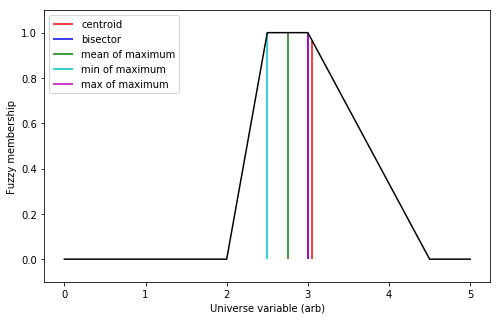

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

%matplotlib inline  

# Generate trapezoidal membership function on range [0, 1]
x = np.arange(0, 5.05, 0.1)
mfx = fuzz.trapmf(x, [2.0, 2.5, 3, 4.5])
print(' x = ', x)

# Defuzzify this membership function five ways
defuzz_centroid = fuzz.defuzz(x, mfx, 'centroid')  # Same as skfuzzy.centroid
defuzz_bisector = fuzz.defuzz(x, mfx, 'bisector')
defuzz_mom = fuzz.defuzz(x, mfx, 'mom')
defuzz_som = fuzz.defuzz(x, mfx, 'som')
defuzz_lom = fuzz.defuzz(x, mfx, 'lom')

# Collect info for vertical lines
labels = ['centroid', 'bisector', 'mean of maximum', 'min of maximum',
          'max of maximum']
xvals = [defuzz_centroid,
         defuzz_bisector,
         defuzz_mom,
         defuzz_som,
         defuzz_lom]
colors = ['r', 'b', 'g', 'c', 'm']
ymax = [fuzz.interp_membership(x, mfx, i) for i in xvals]

# Display and compare defuzzification results against membership function
plt.figure(figsize=(8, 5))

plt.plot(x, mfx, 'k')
for xv, y, label, color in zip(xvals, ymax, labels, colors):
    plt.vlines(xv, 0, y, label=label, color=color)
plt.ylabel('Fuzzy membership')
plt.xlabel('Universe variable (arb)')
plt.ylim(-0.1, 1.1)
plt.legend(loc=2)

plt.show()

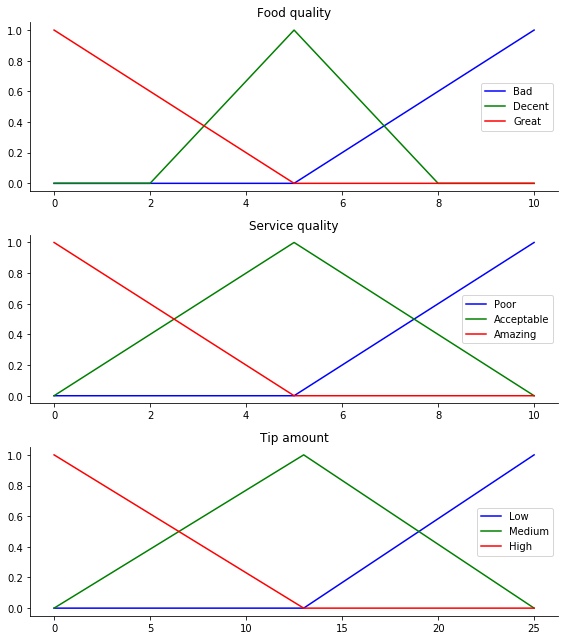

In [2]:
# Generate universe variables
#   * Quality and service on subjective ranges [0, 10]
#   * Tip has a range of [0, 25] in units of percentage points
x_qual = np.arange(0, 11, 1)
x_serv = np.arange(0, 11, 1)
x_tip  = np.arange(0, 26, 1)

# Generate fuzzy membership functions
qual_hi = fuzz.trimf(x_qual, [0, 0, 5])
qual_md = fuzz.trimf(x_qual, [2, 5, 8])
qual_lo = fuzz.trimf(x_qual, [5, 10, 10])
serv_hi = fuzz.trimf(x_serv, [0, 0, 5])
serv_md = fuzz.trimf(x_serv, [0, 5, 10])
serv_lo = fuzz.trimf(x_serv, [5, 10, 10])
tip_hi = fuzz.trimf(x_tip, [0, 0, 13])
tip_md = fuzz.trimf(x_tip, [0, 13, 25])
tip_lo = fuzz.trimf(x_tip, [13, 25, 25])

# Visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_qual, qual_lo, 'b', linewidth=1.5, label='Bad')
ax0.plot(x_qual, qual_md, 'g', linewidth=1.5, label='Decent')
ax0.plot(x_qual, qual_hi, 'r', linewidth=1.5, label='Great')
ax0.set_title('Food quality')
ax0.legend()

ax1.plot(x_serv, serv_lo, 'b', linewidth=1.5, label='Poor')
ax1.plot(x_serv, serv_md, 'g', linewidth=1.5, label='Acceptable')
ax1.plot(x_serv, serv_hi, 'r', linewidth=1.5, label='Amazing')
ax1.set_title('Service quality')
ax1.legend()

ax2.plot(x_tip, tip_lo, 'b', linewidth=1.5, label='Low')
ax2.plot(x_tip, tip_md, 'g', linewidth=1.5, label='Medium')
ax2.plot(x_tip, tip_hi, 'r', linewidth=1.5, label='High')
ax2.set_title('Tip amount')
ax2.legend()

# Turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

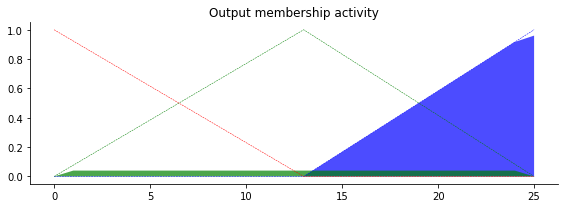

In [3]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
qual_level_lo = fuzz.interp_membership(x_qual, qual_lo, 6.5)
qual_level_md = fuzz.interp_membership(x_qual, qual_md, 6.5)
qual_level_hi = fuzz.interp_membership(x_qual, qual_hi, 6.5)

serv_level_lo = fuzz.interp_membership(x_serv, serv_lo, 9.8)
serv_level_md = fuzz.interp_membership(x_serv, serv_md, 9.8)
serv_level_hi = fuzz.interp_membership(x_serv, serv_hi, 9.8)

# Now we take our rules and apply them. Rule 1 concerns bad food OR service.
# The OR operator means we take the maximum of these two.
active_rule1 = np.fmax(qual_level_lo, serv_level_lo)

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
tip_activation_lo = np.fmin(active_rule1, tip_lo)  # removed entirely to 0

# For rule 2 we connect acceptable service to medium tipping
tip_activation_md = np.fmin(serv_level_md, tip_md)

# For rule 3 we connect high service OR high food with high tipping
active_rule3 = np.fmax(qual_level_hi, serv_level_hi)
tip_activation_hi = np.fmin(active_rule3, tip_hi)
tip0 = np.zeros_like(x_tip)

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_tip, tip0, tip_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_tip, tip0, tip_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')

ax0.fill_between(x_tip, tip0, tip_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
